# SARIMA Model for Energy Demand in Spain
A SARIMA model (Seasonal AutoRegressive Integrated Moving Average) is a type of time series forecasting model that extends ARIMA by incorporating seasonality. It’s effective for data with patterns repeating at regular intervals, like the weekly pattern in energy demand. This model will act as a benchmark for more complex ML models.

## SARIMA Components:
SARIMA is defined by the parameters: (p, d, q) × (P, D, Q, s), where:

- Non-Seasonal Components (ARIMA part):
    - p (Auto-Regressive order): Number of past observations to use for predicting future values (lagged terms).
    - d (Differencing order): Number of times the data needs to be differenced to make it stationary.
    - q (Moving Average order): Number of lagged forecast errors to include in the model.
- Seasonal Components:
    - P (Seasonal Auto-Regressive order): Number of seasonal lags (e.g., past seasons) to include for prediction.
    - D (Seasonal Differencing order): Number of seasonal differences to make the data stationary for seasonal patterns.
    - Q (Seasonal Moving Average order): Number of seasonal lagged forecast errors to include.
    - s (Seasonal period): Number of time steps in a season (e.g., 24 for hourly data with daily seasonality).

## Visualising Energy Demand

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import pmdarima
from scipy.stats import probplot
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('data/actualTotalLoad.csv')
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df.set_index('datetime', inplace=True)

df.describe()

,Actual Total Load (MW)
count,43849.000000
mean,26952.362927
std,4372.156334
min,16144.000000
25%,23416.000000
50%,26924.000000
75%,30224.000000
max,41754.000000


<Axes: >

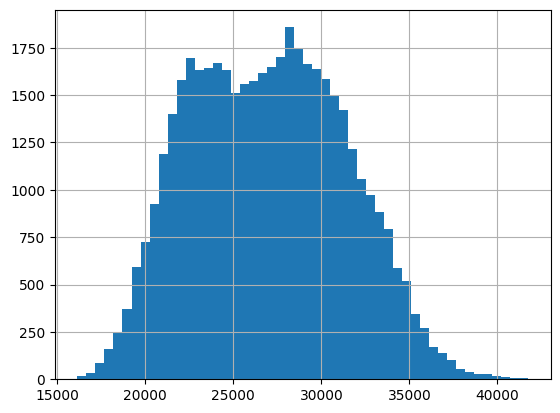

In [3]:
df['Actual Total Load (MW)'].hist(bins=50)

This shows that energy demand roughly follows a Normal distribution, thus could be standardised.

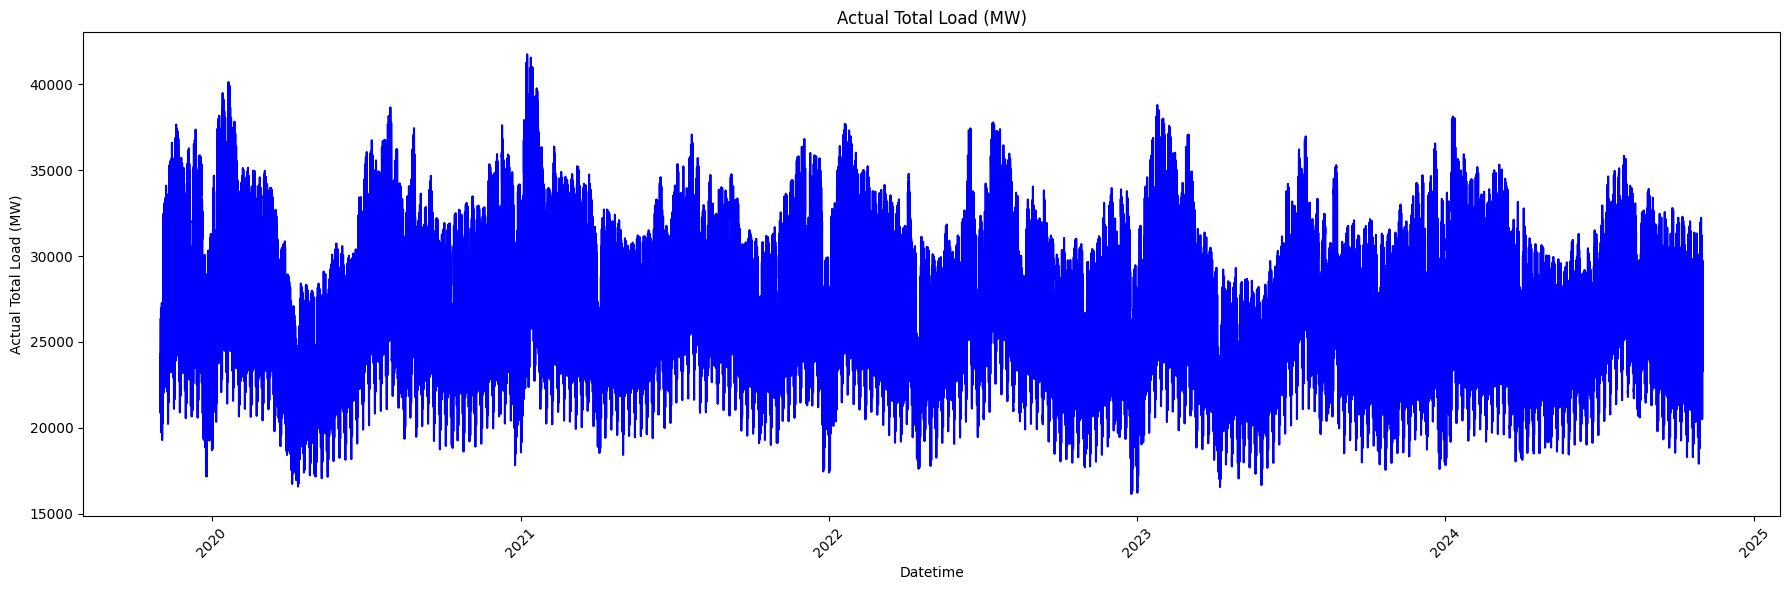

In [16]:
plt.figure(figsize=(18, 6))
plt.plot(df['Actual Total Load (MW)'], linestyle='-', color='b')

plt.title('Actual Total Load (MW)')
plt.xlabel('Datetime')
plt.ylabel('Actual Total Load (MW)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Finding Seasonsal Period

Breaking down the data into `Observed=Trend+Seasonality+Residual` helps visualise any seasonality. Hourly, weekly and yearly seasonality will be considered.

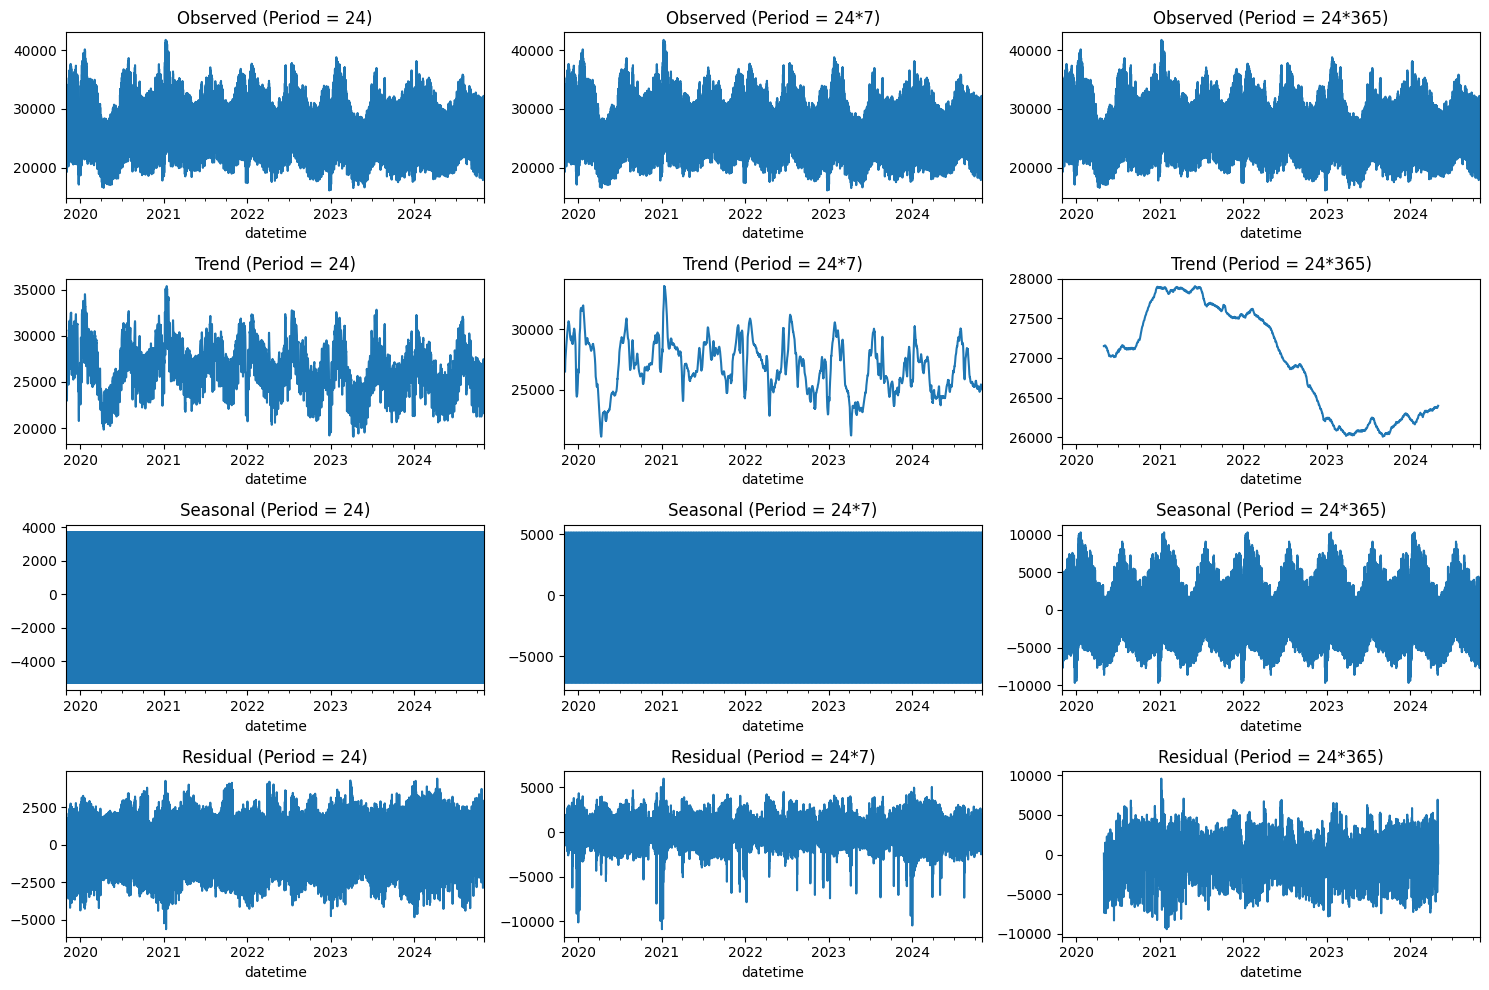

In [5]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10))

# Decompose the data with different periods
result_24 = sm.tsa.seasonal.seasonal_decompose(df['Actual Total Load (MW)'], model='additive', period=24)
result_24_7 = sm.tsa.seasonal.seasonal_decompose(df['Actual Total Load (MW)'], model='additive', period=24*7)
result_24_365 = sm.tsa.seasonal.seasonal_decompose(df['Actual Total Load (MW)'], model='additive', period=24*365)

# Plot for Period = 24
result_24.observed.plot(ax=axes[0, 0], title='Observed (Period = 24)')
result_24.trend.plot(ax=axes[1, 0], title='Trend (Period = 24)')
result_24.seasonal.plot(ax=axes[2, 0], title='Seasonal (Period = 24)')
result_24.resid.plot(ax=axes[3, 0], title='Residual (Period = 24)')
# Plot for Period = 24*7
result_24_7.observed.plot(ax=axes[0, 1], title='Observed (Period = 24*7)')
result_24_7.trend.plot(ax=axes[1, 1], title='Trend (Period = 24*7)')
result_24_7.seasonal.plot(ax=axes[2, 1], title='Seasonal (Period = 24*7)')
result_24_7.resid.plot(ax=axes[3, 1], title='Residual (Period = 24*7)')

# Plot for Period = 24*365
result_24_365.observed.plot(ax=axes[0, 2], title='Observed (Period = 24*365)')
result_24_365.trend.plot(ax=axes[1, 2], title='Trend (Period = 24*365)')
result_24_365.seasonal.plot(ax=axes[2, 2], title='Seasonal (Period = 24*365)')
result_24_365.resid.plot(ax=axes[3, 2], title='Residual (Period = 24*365)')

plt.tight_layout()
plt.show()

This doesn't allow for a clear view of daily or weekly seasonality, but does show yearly seasonality. For an ARIMA model for hourly data, yearly seasonality won't be captured because the window of lagged terms will not be sufficiently large. Therefore, for this benchmark model, yearly seasonality will be ignored. 

Importantly, the residuals for hourly and yearly periods resembles white noise, suggesting the models have successfully captured most aspects of the data. The large negative spikes in the weekly periods are likely explained by public holidays, where less energy is needed. Ignoring these outliers, weekly seasonality also has residuals that resembles white noise.

To capture a better of view of hourly and weekly seasonality either a shorter period of data must be used, or a mean must be taken.

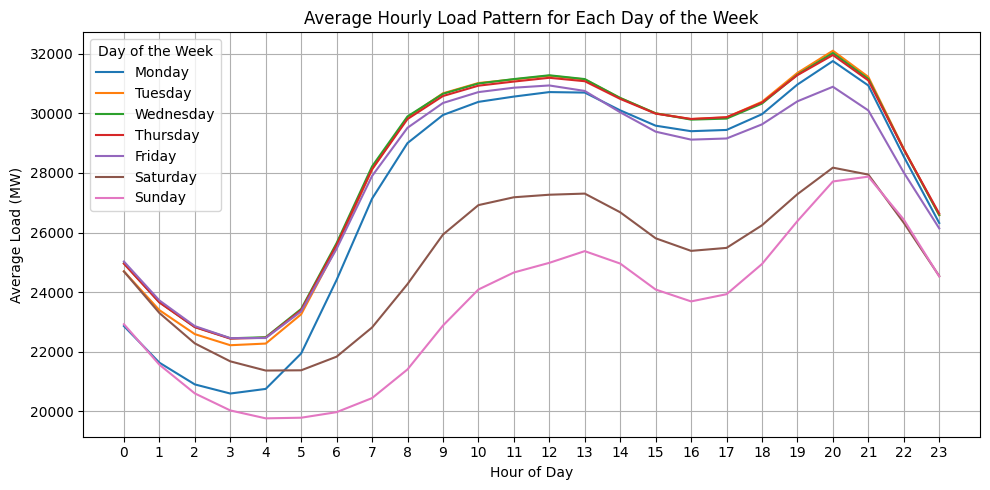

In [6]:
df['day_of_week'] = df.index.dayofweek  # Monday=0, Sunday=6
df['hour'] = df.index.hour

# Group by day of the week and hour, then calculate the mean
weekly_pattern = (
    df.groupby(['day_of_week', 'hour'])['Actual Total Load (MW)']
    .mean()
    .reset_index()
)

# Create a pivot table for easier plotting
pivot = weekly_pattern.pivot(index='hour', columns='day_of_week', values='Actual Total Load (MW)')

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10, 5))

for day_idx, day in enumerate(days):
    plt.plot(pivot.index, pivot[day_idx], label=day)

plt.title('Average Hourly Load Pattern for Each Day of the Week')
plt.xlabel('Hour of Day')
plt.ylabel('Average Load (MW)')
plt.xticks(range(0, 24), labels=range(0, 24))
plt.legend(title='Day of the Week')
plt.grid()

plt.tight_layout()
plt.show()

This shows a clear daily repeating pattern that the SARIMA model should capture. This also shows a weekly seasonality, with lower energy usage on Saturday and Sunday, and since an SARIMA model only allows for one seasonal period, we will model for a weekly trend as this will also capture the daily trend. It is possible to incorporate multiple trends, i.e. daily, into a model of this kind by using a SARIMAX model, which allows the inclusion of exogenous variables (external predictors) to improve the model. In this case, Fourier terms for additional seasonalities would be treated as exogenous variables. However, since this model is going to act as a benchmark we want to keep it as simple as possible.

**Therefore, in this model s = 24*7 = 168**

## Stationarity

A SARIMA model assumes stationarity because it relies on constant statistical properties (mean, variance, and autocorrelation) to accurately model relationships and forecast future values. Non-stationary data can lead to misleading results as the model cannot properly account for time-dependent changes in the data.

However, SARIMA models can handle non-stationary time series by incorporating differencing parameters (d for trend differencing and D for seasonal differencing) to transform the series into a stationary one.

### Augmented Dickey-Fuller (ADF) test

The ADF test is a statistical test used to determine whether a given time series is stationary or has a unit root (non-stationary). Its hypotheses are the following:

 - Null Hypothesis  H0 : The time series has a unit root, meaning the series is non-stationary (it has a trend or random walk behavior).
 - Alternate Hypothesis  H1 : The time series has no unit root and is either stationary or can be made stationary using differencing.

By default `statsmodels.tsa.stattools.adfuller` uses Schwarz Information Criterion (SIC) to select the optimal number of lags. 

In [7]:
adf_test = sm.tsa.stattools.adfuller(df['Actual Total Load (MW)'])
print(f'ADF Statistic: {adf_test[0]:.6f}\n'
    f'p-value: {adf_test[1]:.6f}\n'
    f'#Lags used: {adf_test[2]}')

for key, value in adf_test[4].items():
    print(f'Critical Value ({key}): {value:.6f}')

ADF Statistic: -17.651512
p-value: 0.000000
#Lags used: 55
Critical Value (1%): -3.430499
Critical Value (5%): -2.861606
Critical Value (10%): -2.566805


The ADF statistic (-17.652) is less than the critical value at 1% (-3.430) and thus, we can say that we **reject the null hypothesis  H0** with a significance level 1%, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

**Therefore, in this model d = 1**

In [8]:
seasonal_period = 24*7

# Apply seasonal differencing
seasonally_differenced = df['Actual Total Load (MW)'].diff(seasonal_period).dropna()

adf_test = sm.tsa.stattools.adfuller(seasonally_differenced)
print(f'ADF Statistic: {adf_test[0]:.6f}\n'
    f'p-value: {adf_test[1]:.6f}\n'
    f'#Lags used: {adf_test[2]}')

for key, value in adf_test[4].items():
    print(f'Critical Value ({key}): {value:.6f}')

ADF Statistic: -15.413978
p-value: 0.000000
#Lags used: 49
Critical Value (1%): -3.430500
Critical Value (5%): -2.861606
Critical Value (10%): -2.566805


The seasonal component also needs to be tested for stationarity. It requires applying seasonal differencing before the ADF test.

The ADF statistic (-15.41) is less than the critical value at 1% (-3.430) and thus, we can say that we **reject the null hypothesis  H0** with a significance level 1%, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

**Therefore, in this model D = 1**

## Autocorrelation Function (ACF) & Partial Autocorrelation Function (PACF)

The ACF and PACF are key tools for determining the q and p parameters in (S)ARIMA models. 
- ACF : measures the correlation between a time series and its lags, helping to identify the q (Moving Average) terms based on where the autocorrelation significantly cuts off.
- PACF : measures the direct relationship between a time series and its lags by removing the effects of any correlations explained by shorter lags. It is used to identify the p (Autoregressive) terms where partial autocorrelation significantly cuts off.
- The optimal values for p and q are estimated based on the number of lags before a value is within the confidence interval. This doesn't include the value at lag=0, as this will always have a value of 1.
- This extends to P and Q in a SARIMA model, but instead of a lag being just one timestep, it is a whole period. In this case 168 hours.

First p and q will be calculated using the time series with the daily seasonal component removed:

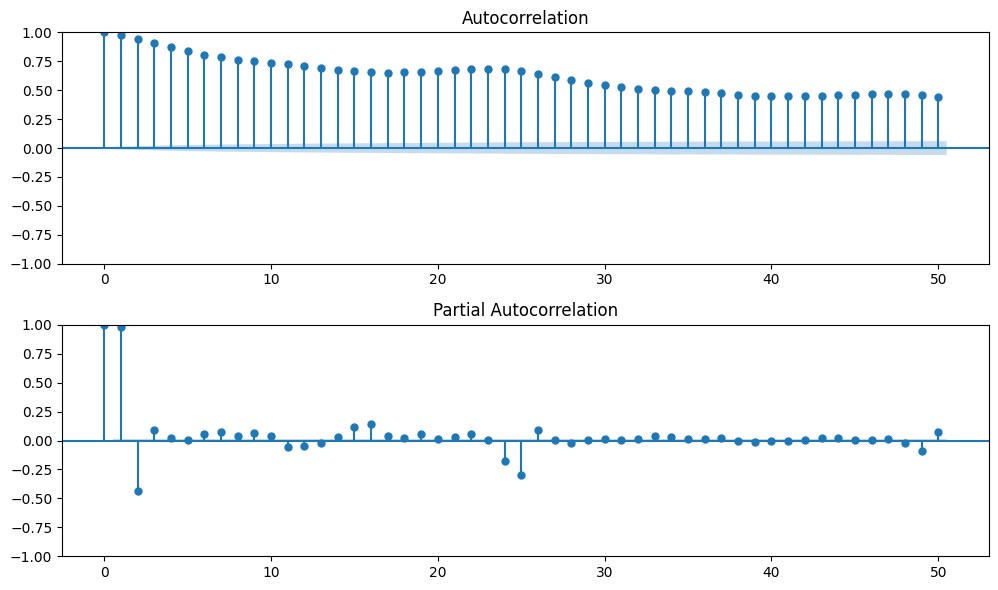

In [9]:
seasonally_differenced = df['Actual Total Load (MW)'].diff(seasonal_period).dropna()

# Plot autocorrelation and partial autocorrelation plots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(seasonally_differenced, lags=50, ax=ax1)
plot_pacf(seasonally_differenced, lags=50, ax=ax2)
plt.tight_layout()
plt.show()

Based on the first lags where the ACF and PACF are within the confidence interval: **In this model, q = 50 and p = 3.** The ACF is not within the confidence interval after 50 lags, so a value of 50 will be used.

To calculate P and Q for a seasonal ARIMA model, the time series will be separated into 168 different subsets, each containing data from the same hour and same day of each week (e.g., all data points at 1 AM Monday, 2 AM Monday, etc.). This effectively changes the lag between consecutive data points in each subset to 168 hours instead of 1 hour. The ACF and PACF will then be calculated for each of these 168 subsets, and the results will be averaged across all hours to estimate the seasonal P (autoregressive) and Q (moving average) terms.

To my knowledge this is a novel approach, which ensures that any consistent patterns in the same hour across different days are emphasized, which can help isolate daily seasonal effects.

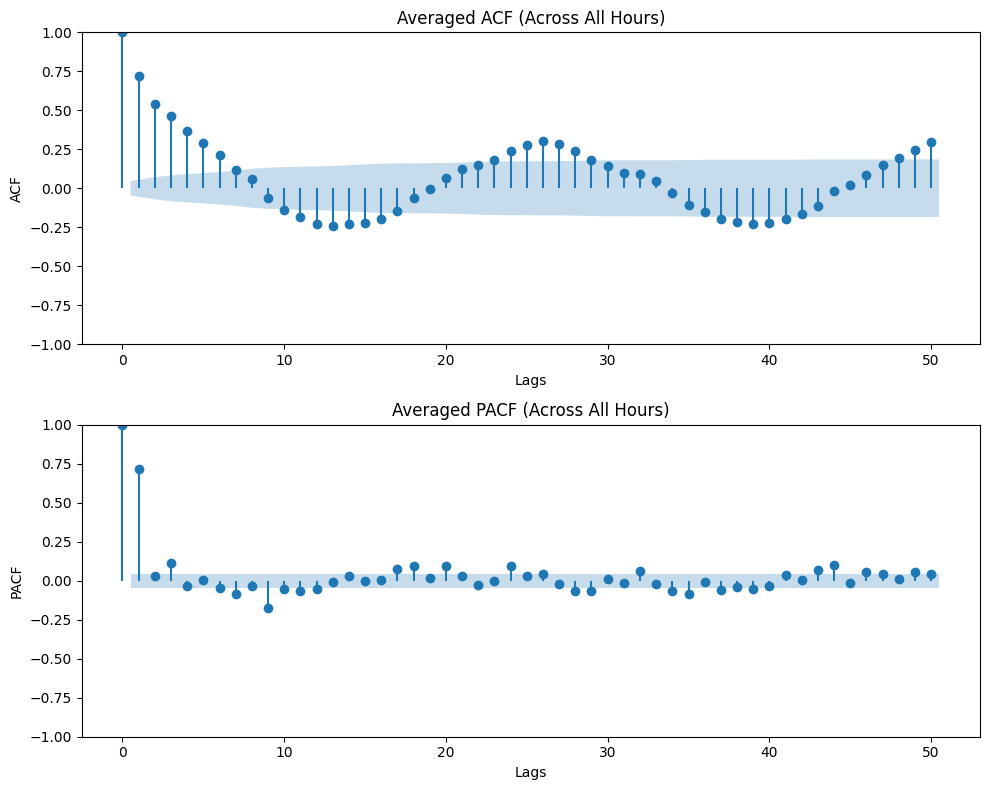

In [10]:
acf_values = []
pacf_values = []

for hour in range(168):
    hour_data = df[(df['hour'] == hour % 24) & (df['day_of_week'] == hour // 24)]['Actual Total Load (MW)']
    
    # Calculate ACF and PACF for the current hour's data
    acf_vals = acf(hour_data, nlags=50, fft=True)
    pacf_vals = pacf(hour_data, nlags=50)
    
    acf_values.append(acf_vals)
    pacf_values.append(pacf_vals)

acf_values = np.array(acf_values)
pacf_values = np.array(pacf_values)

# Average the ACF and PACF values across all hours
avg_acf = np.mean(acf_values, axis=0)
avg_pacf = np.mean(pacf_values, axis=0)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plotted and then the stems are hidden just to get the confidence intervals
plot_acf(df[df['hour'] == 1]['Actual Total Load (MW)'], lags=50, ax=axes[0], markersize=0, use_vlines=False)
plot_pacf(df[df['hour'] == 1]['Actual Total Load (MW)'], lags=50, ax=axes[1], markersize=0, use_vlines=False)

axes[0].stem(np.arange(len(avg_acf)), avg_acf, basefmt=" ")
axes[0].set_title('Averaged ACF (Across All Hours)')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('ACF')
axes[1].stem(np.arange(len(avg_pacf)), avg_pacf, basefmt=" ")
axes[1].set_title('Averaged PACF (Across All Hours)')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()


Based on the first lags where the ACF and PACF are within the confidence interval: **In this model, P = 1 and Q = 6.**

We now have all our parameters:
- p = 3
- q = 50
- d = 1
- P = 1
- Q = 6
- D = 1
- s = 168

These are estimates of the optimal parameters for the model, but training this large number of parameters is computationally expensive, especially with such a large seasonal period. 

## Minimising Akaike Information Criteria (AIC)

The parameter values will be instead be obtained by minimising the Akaike Information Criteria (AIC), using a 500 data point window for training the model. This number of data points should be sufficient to effectively capture the autocorrelations and trends in the data. A number of different parameter combinations of p,q,P,Q will be trialed, and the resulting AIC values plotted.

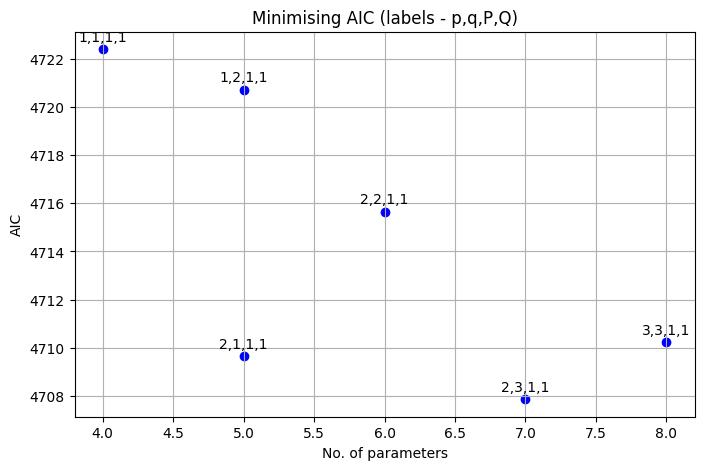

In [11]:
x_values = [4, 5, 6, 8, 5, 7]
y_values = [4722.405, 4720.731, 4715.653, 4710.219, 4709.638, 4707.860]

labels = [
    "1,1,1,1", "1,2,1,1", "2,2,1,1", "3,3,1,1", "2,1,1,1", "2,3,1,1"
]

plt.figure(figsize=(8, 5))
plt.scatter(x_values, y_values, color='blue')

for i, label in enumerate(labels):
    plt.annotate(label, (x_values[i], y_values[i]), textcoords="offset points", xytext=(0, 6), ha='center')

plt.xlabel('No. of parameters')
plt.ylabel('AIC')
plt.title('Minimising AIC (labels - p,q,P,Q)')
plt.grid(True)
plt.show()

The plot above shows the optimal parameters which minimise AIC are **(p,d,q,P,D,Q) = (2,1,3,1,1,1)**. 

Below, the Q-Q plot of the residuals using these parameters shows a residual distribution which largely follows a normal distribution, with slightly fat-tails. This suggests this SARIMA model has not fully captured the underlying structure of the data, particularly the extreme values or outliers. This is expected since no exogenous variables, like weather and public holidays, have yet been introduced.

                                       SARIMAX Results                                       
Dep. Variable:                             D.DS168.y   No. Observations:                  331
Model:             SARIMAX(2, 0, 3)x(1, 0, [1], 168)   Log Likelihood               -2344.930
Date:                               Thu, 05 Dec 2024   AIC                           4707.860
Time:                                       15:52:05   BIC                           4742.079
Sample:                                   11-08-2019   HQIC                          4721.508
                                        - 11-21-2019                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.5301     12.624     -0.121      0.904     -26.273      23.213
ar.L1      

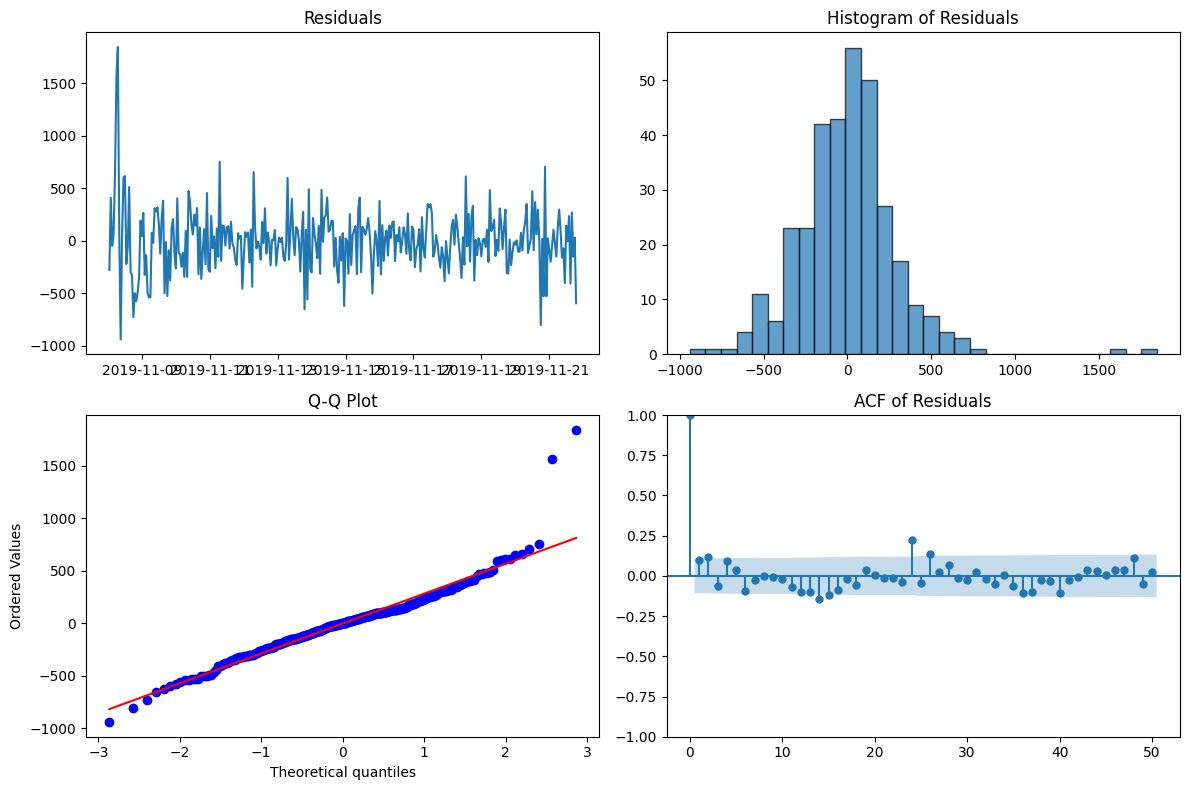

In [12]:
df_train = df.iloc[:500]

model = pmdarima.ARIMA(
            order=(2, 1, 3),  # (p, d, q)
            seasonal_order=(1, 1, 1, 24*7),  # (P, D, Q, s)
            suppress_warnings=True,
            simple_differencing=True
        )
model.fit(df_train['Actual Total Load (MW)'])

print(model.summary())

residuals = model.resid()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot residuals
axes[0, 0].plot(residuals)
axes[0, 0].set_title("Residuals")

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor="k", alpha=0.7)
axes[0, 1].set_title("Histogram of Residuals")

# Q-Q plot
probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Q-Q Plot")

# ACF of residuals
plot_acf(residuals, lags=50, ax=axes[1, 1])
axes[1, 1].set_title("ACF of Residuals")

plt.tight_layout()
plt.show()


## Fitting the SARIMA Model

SARIMA models only allow predictions for time steps directly following the end of the data used to train the model. For example, if the 500 data points used to train the model end at 2024-01-01 12:00, then then model can only make predictions for 2024-01-01 13:00. It can then also use this prediction to make a further prediction for 2024-01-01 14:00 etc. Any error made in earlier predictions will propagate into later predictions. 

A work around for this limitation is creating a new model for new data (e.g. a later date), but using the same parameters as the previously trained model and specifying 0 optimisation iterations. Avoiding retraining the model greatly reduces the time to obtain the predictions.

This model needs to be able to predict the hourly demand for the next day by the time the day ahead market closes, so at 12:00. Therfore, the model will need to forecast 36 hours ahead; 12 hours to get to 00:00 and then 24 hours of day ahead predictions.

A rolling forecast is required to generate these predictions, with a new SARIMA model being fit for every 30 days in the test date range (2023-11-01 00:00 -> 2024-11-01 00:00). Each model will be fit using the 500 previous data points before 12:00 on the day from which the prediction is made. Using the work around allows the same model to be used for every date within each given 30 day period.

In [ ]:
# Parameters for SARIMA
order = (2, 1, 3)  # (p, d, q)
seasonal_order = (1, 1, 1, 24*7)  # (P, D, Q, s)

# Forecast Horizon (35 hours: 12 hours to get to midnight, plus 23 hours of predictions)
forecast_hours = 35

# List to store rolling forecast predictions
forecast_values = []

initial_prediction_date = pd.Timestamp('2023-10-31 12:00')

train_data = df[(df.index <= initial_prediction_date) & (df.index > initial_prediction_date - pd.Timedelta(hours=500))]

# Fit the SARIMA model to the training data
model = pmdarima.ARIMA(
        order=order,
        seasonal_order=seasonal_order,
        suppress_warnings=True, maxiter=10
    )
model.fit(train_data['Actual Total Load (MW)'])

# print(model.summary())

# Make predictions
forecast = model.predict(n_periods = forecast_hours)
# Store the forecast values
forecast_values.extend(forecast[11:])


# Define the rolling forecast process for a year
for i in range(1, 366):
    print(i)

    # Determine the starting point of the training data (last 500 data points before the prediction day)
    train_data_end = initial_prediction_date + pd.Timedelta(days=i)

    if i % 30 == 0:

        train_data_start = train_data_end - pd.Timedelta(hours=500)
        
        # Create the training data slice for the current prediction day
        train_data = df[(df.index > train_data_start) & (df.index <= train_data_end)]

        model = pmdarima.ARIMA(
                order=order,
                seasonal_order=seasonal_order,
                suppress_warnings=True, maxiter=10,
            )
        model.fit(train_data['Actual Total Load (MW)'])
    
    else:

        train_data_start = train_data_end - pd.Timedelta(hours=169)
        
        # Create the training data slice for the current prediction day
        train_data = df[(df.index > train_data_start) & (df.index <= train_data_end)]

        model = pmdarima.ARIMA(
                order=order,
                seasonal_order=seasonal_order,
                suppress_warnings=True, maxiter=0, method = 'nm',
                start_params=model.params()
            )
        model.fit(train_data['Actual Total Load (MW)'])

    # print(model.summary())

    # Make predictions
    forecast = model.predict(n_periods = forecast_hours)
    # Store the forecast values
    forecast_values.extend(forecast[11:])

predictions = pd.DataFrame(forecast_values, columns=['SARIMA Prediction'])
predictions.to_csv('demand_prediction.csv', index=False)

The code above takes a significant amount of time to run, so the results are saved to 'demand_prediction.csv' for convenience.

In [ ]:
# Save predictions to new csv
predictions = pd.read_csv('data/demand_prediction.csv')
df_test = df[(df.index >= '2023-11-01 00:00') & (df.index < '2024-11-01 00:00')]
forecast_values = predictions['SARIMA Prediction'].to_list()
df_test['SARIMA Prediction'] = forecast_values

output_df = df_test[['Actual Total Load (MW)', 'SARIMA Prediction']].copy()
output_df.to_csv('data/demand_prediction.csv', index=True)

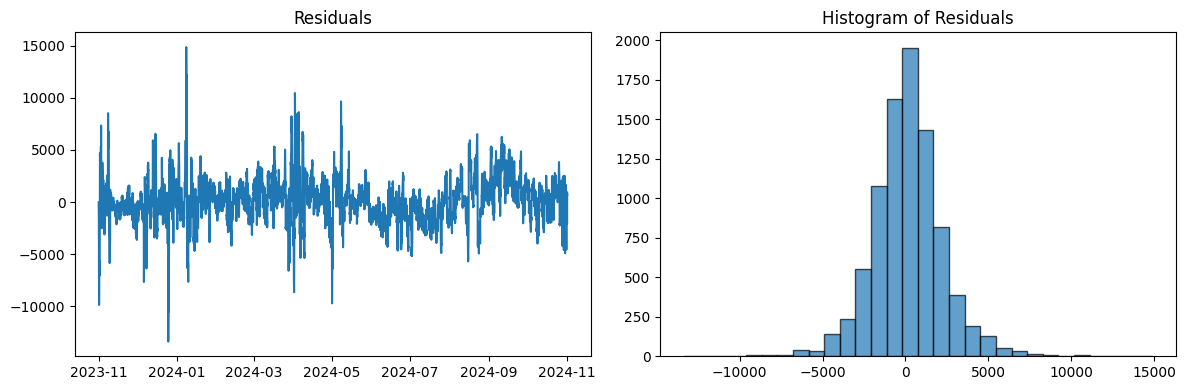

RMSE : 2161.1438366925386
MAE : 1575.876012516152


In [13]:
predictions = pd.read_csv('data/demand_prediction.csv')
predictions['datetime'] = pd.to_datetime(predictions['datetime'], errors='coerce')
predictions.set_index('datetime', inplace=True)

predictions['residuals'] = predictions['Actual Total Load (MW)'] - predictions['SARIMA Prediction']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot residuals
axes[0].plot(predictions['residuals'])
axes[0].set_title("Residuals")

# Histogram of residuals
axes[1].hist(predictions['residuals'], bins=30, edgecolor="k", alpha=0.7)
axes[1].set_title("Histogram of Residuals")

plt.tight_layout()
plt.show()

rmse = np.sqrt(mean_squared_error(predictions['Actual Total Load (MW)'], predictions['SARIMA Prediction']))
mae = mean_absolute_error(predictions['Actual Total Load (MW)'], predictions['SARIMA Prediction'])

print(f'RMSE : {rmse}')
print(f'MAE : {mae}')

## Previous-Week Forecast Benchmark

A simple benchmark which simply uses the energy demand from the previous week as a prediction for future energy demands. This will be compared to the SARIMA model's performance.

In [ ]:
# Generate predictions
df['prediction'] = df['Actual Total Load (MW)'].shift(168)
df_test = df[(df.index >= '2023-11-01 00:00') & (df.index < '2024-11-01 00:00')]

# Save predictions to new csv
predictions = pd.read_csv('data/demand_prediction.csv')
predictions['datetime'] = pd.to_datetime(predictions['datetime'], errors='coerce')
predictions.set_index('datetime', inplace=True)
predictions['Previous-Week Prediction'] = df_test['prediction']

predictions.to_csv('data/demand_prediction.csv', index=True)

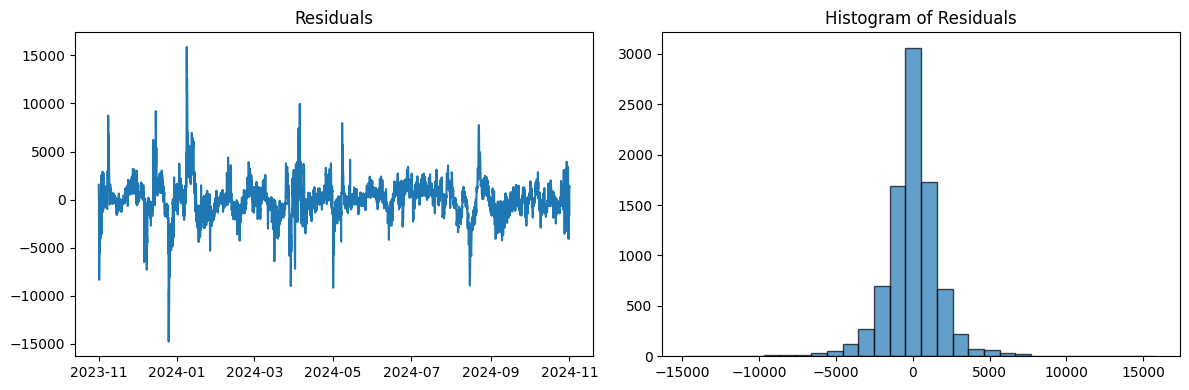

RMSE : 1822.592475434879
MAE : 1207.4430783242258


In [14]:
predictions = pd.read_csv('data/demand_prediction.csv')
predictions['datetime'] = pd.to_datetime(predictions['datetime'], errors='coerce')
predictions.set_index('datetime', inplace=True)

predictions['residuals'] = predictions['Actual Total Load (MW)'] - predictions['Previous-Week Prediction']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot residuals
axes[0].plot(predictions['residuals'])
axes[0].set_title("Residuals")

# Histogram of residuals
axes[1].hist(predictions['residuals'], bins=30, edgecolor="k", alpha=0.7)
axes[1].set_title("Histogram of Residuals")

plt.tight_layout()
plt.show()

rmse = np.sqrt(mean_squared_error(predictions['Actual Total Load (MW)'], predictions['Previous-Week Prediction']))
mae = mean_absolute_error(predictions['Actual Total Load (MW)'], predictions['Previous-Week Prediction'])

print(f'RMSE : {rmse}')
print(f'MAE : {mae}')


## Summary


The SARIMA model, with an RMSE of 2161.14 and an MAE of 1575.88, performed worse in predicting energy demand compared to the simple previous-week forecast, which achieved an RMSE of 1822.59 and an MAE of 1207.44. This suggests that the SARIMA model struggled to capture the underlying patterns in the data effectively, possibly due to overfitting, misrepresentation of seasonal trends or its inability to model non-linear dynamics. In contrast, the previous-week forecast, a straightforward benchmark, leveraged the strong weekly periodicity in energy demand, demonstrating superior accuracy and highlighting the importance of simpler models in cases with dominant and consistent seasonal patterns.

Therefore, the previous-week forecast will serve as a baseline benchmark for evaluating the performance of more advanced machine learning models. By establishing a simple, intuitive reference point, we can assess whether more complex models provide meaningful improvements in accuracy. Future efforts will focus on leveraging machine learning approaches, such as gradient boosting or neural networks, which are better equipped to capture non-linearities, interactions, and subtle temporal dynamics in the data. With these models, we aim to achieve a better fit and improve predictive performance, reducing the errors seen in both RMSE and MAE compared to the benchmark.